In [1]:
import numpy as np
import json
import codecs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
from model import my_aggclustering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
msdat_dir = '/home/hpms/Microsoft.IoT-Dump1.json'
with codecs.open(msdat_dir, 'r', 'utf-8-sig') as f:
    msdat = json.load(f)
msdat = pd.DataFrame(msdat)
msdat['Commands'] = [tuple(session) for session in msdat['Commands']]
msdat = msdat.drop_duplicates(subset='Commands').reset_index(drop=True)  # drop duplicates
msdat['Commands'] = [list(session) for session in msdat['Commands']]
msdat['Commands Length'] = [len(session) for session in msdat['Commands']]
msdat = msdat.sort_values(by='FirstSeen').reset_index(drop=True)

In [3]:
n_session = len(msdat)

### Baseline

In [4]:
# alpha_cluster = 0.1
# cluster_threshold = -np.inf
# alpha_label = 0.1
# init_commands_num = 1
# seq_len = 12
# my_agg = my_aggclustering(msdat[:int(n_session*0.9)], alpha_cluster, cluster_threshold, alpha_label, init_commands_num, seq_len)
# my_agg.fit()
# with open('agg_data/aggclustering_9010_baseline.pkl', 'wb') as f:
#     pickle.dump(my_agg, f, protocol=4)

Clustering started. Total 1716 clusters. Clustering finished. Time spent: 75.13s.


In [32]:
with open('agg_data/aggclustering_9010_baseline.pkl', 'rb') as f:
    my_agg = pickle.load(f)
clustering = my_agg.memory['clustering']
init_commands_list = my_agg.memory['init_commands_list']
posterior_dict = my_agg.memory['posterior_dict']
expected_predictive_prob = my_agg.memory['expected_predictive_prob']
A = my_agg.memory['A']
E = my_agg.memory['E']
seq_rank_list = my_agg.memory['seq_rank_list']
weights = my_agg.memory['weights']

In [6]:
score_list = my_agg.predict(msdat[int(n_session*0.9):])

In [7]:
print('Average score for baseline is {:.5f}.'.format(np.mean(score_list)))

Average score for baseline is 0.28793.


### Different number of initial commands

alpha_cluster = 0.1 

cluster_threshold = -0.1

alpha_label = 0.1

init_commands_num = 1/2/3/4/5/6/7/8

seq_len = 12

In [4]:
alpha_cluster = 0.1
cluster_threshold = -0.1
alpha_label = 0.1
seq_len = 12

In [8]:
# for init_commands_num in range(1,9):
#     my_agg = my_aggclustering(msdat[:int(n_session*0.9)], alpha_cluster, cluster_threshold, alpha_label, init_commands_num, seq_len)
#     my_agg.fit()
#     with open('agg_data/aggclustering9010_{}init.pkl'.format(init_commands_num), 'wb') as f:
#         pickle.dump(my_agg, f, protocol=4)

Clustering started. Total 16 clusters. Clustering finished. Time spent: 71.49s.
Clustering started. Total 35 clusters. Clustering finished. Time spent: 844.86s.
Clustering started. Total 38 clusters. Clustering finished. Time spent: 2539.52s.
Clustering started. Total 32 clusters. Clustering finished. Time spent: 4496.31s.
Clustering started. Total 36 clusters. Clustering finished. Time spent: 5036.33s.
Clustering started. Total 33 clusters. Clustering finished. Time spent: 10095.50s.
Clustering started. Total 36 clusters. Clustering finished. Time spent: 15140.97s.
Clustering started. Total 38 clusters. Clustering finished. Time spent: 16614.87s.


In [33]:
score_lists = []
for init_commands_num in range(1,9):
    with open('agg_data/aggclustering9010_{}init.pkl'.format(init_commands_num), 'rb') as f:
        my_agg = pickle.load(f)
    expected_predictive_prob = my_agg.memory['expected_predictive_prob']
    weights = my_agg.memory['weights']
    score_lists.append(my_agg.predict(msdat[int(n_session*0.9):]))

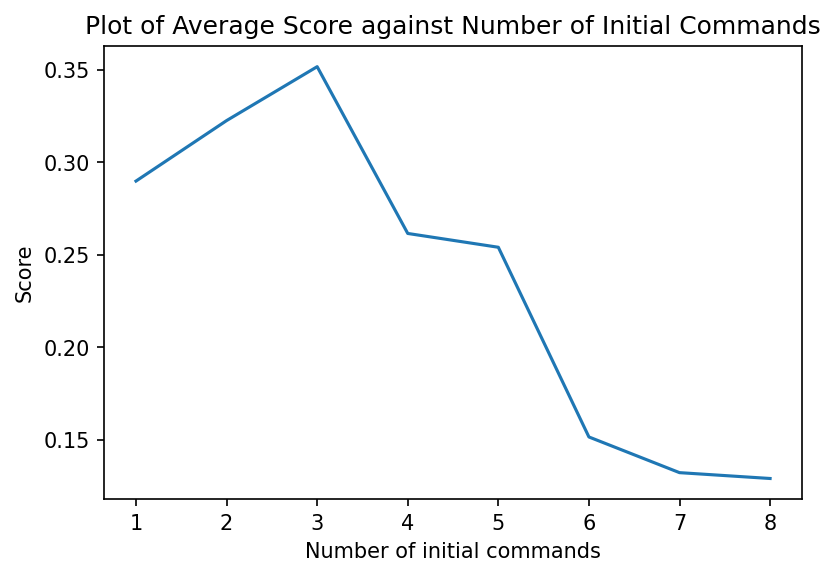

In [41]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
sns.lineplot(x = [i for i in range(1,9)], y = [np.mean(score) for score in score_lists],ax=ax)
ax.set(title='Plot of Average Score against Number of Initial Commands',
       xlabel='Number of initial commands',
       ylabel='Score'
      )
plt.show()

#### Comments

The average score increases from 1 to 3 initial commands as expected. However, the score decreases sharply from 4 to 8.

### Find Optimal Distance Threshold for Clustering

alpha_cluster = 0.1 

alpha_label = 0.1

init_commands_num = 1/2/3/4/5/6/7/8

seq_len = 12

In [10]:
alpha_cluster = 0.1
alpha_label = 0.1
seq_len = 12

In [6]:
for init_commands_num in range(1,9):
    start_time = time.time()
    print('{} initial commands started.'.format(init_commands_num), end=' ')
    with open('agg_data/aggclustering9010_{}init.pkl'.format(init_commands_num), 'rb') as f:
        my_agg = pickle.load(f)
        A = my_agg.memory['A']
        E = my_agg.memory['E']
        seq_rank_list = my_agg.memory['seq_rank_list']
        init_commands_list = my_agg.memory['init_commands_list']
        
    optim_ct = 0
    optim_score = 0
    optim_memory = 0
    
    for ct in np.arange(-0.05, -0.51, -0.05):
        my_agg = my_aggclustering(msdat[:int(n_session*0.9)], alpha_cluster, ct, alpha_label, init_commands_num, seq_len)
        memory = my_agg.fit(A, init_commands_list, seq_rank_list, E, full_memory=False, verbose=False)
        score = my_agg.predict(msdat[int(n_session*0.9):])
        if np.mean(score)>np.mean(optim_score):
            optim_ct = ct
            optim_score = score
            optim_memory = memory
    with open('agg_data/aggclustering9010_{}init_optimct.pkl'.format(init_commands_num), 'wb') as f:
        pickle.dump((optim_ct, optim_score, optim_memory), f, protocol=4)
    print('Finished! Time spent {:.2f}s. Optimal threshold: {:.2f}. Optimal avg score: {:.2f}.'.format(time.time()-start_time, optim_ct, np.mean(optim_score)))

1 initial commands started. Finished! Time spent 74.69s. Optimal threshold: -0.50. Optimal avg score: 0.29.
2 initial commands started. Finished! Time spent 162.28s. Optimal threshold: -0.10. Optimal avg score: 0.32.
3 initial commands started. Finished! Time spent 278.11s. Optimal threshold: -0.35. Optimal avg score: 0.35.
4 initial commands started. Finished! Time spent 455.73s. Optimal threshold: -0.45. Optimal avg score: 0.27.
5 initial commands started. Finished! Time spent 524.34s. Optimal threshold: -0.20. Optimal avg score: 0.26.
6 initial commands started. Finished! Time spent 921.50s. Optimal threshold: -0.20. Optimal avg score: 0.16.
7 initial commands started. Finished! Time spent 1203.42s. Optimal threshold: -0.20. Optimal avg score: 0.14.
8 initial commands started. Finished! Time spent 1277.21s. Optimal threshold: -0.20. Optimal avg score: 0.13.


In [14]:
cluster_nums = []
for init_commands_num in range(1,9):
    with open('agg_data/aggclustering9010_{}init_optimct.pkl'.format(init_commands_num), 'rb') as f:
        _, _, optim_memory = pickle.load(f)
        cluster_nums.append(optim_memory['clustering'].n_clusters_)
print('number of clusters are {}.'.format(cluster_nums))

number of clusters are [18, 35, 46, 55, 45, 45, 49, 52].


In [30]:
# for init_commands_num in range(4,9):
#     start_time = time.time()
#     print('{} initial commands started.'.format(init_commands_num), end=' ')
#     with open('agg_data/aggclustering9010_{}init.pkl'.format(init_commands_num), 'rb') as f:
#         my_agg = pickle.load(f)
#         A = my_agg.memory['A']
#         E = my_agg.memory['E']
#         seq_rank_list = my_agg.memory['seq_rank_list']
#         init_commands_list = my_agg.memory['init_commands_list']
        
#     optim_ct = 0
#     optim_score = 0
#     optim_memory = 0
    
#     for ct in np.arange(-0.01, -0.05, -0.01):
#         my_agg = my_aggclustering(msdat[:int(n_session*0.9)], alpha_cluster, ct, alpha_label, init_commands_num, seq_len)
#         memory = my_agg.fit(A, init_commands_list, seq_rank_list, E, full_memory=False, verbose=False)
#         score = my_agg.predict(msdat[int(n_session*0.9):])
#         if np.mean(score)>np.mean(optim_score):
#             optim_ct = ct
#             optim_score = score
#             optim_memory = memory
#     with open('agg_data/aggclustering9010_{}init_optimct.pkl'.format(init_commands_num), 'wb') as f:
#         pickle.dump((optim_ct, optim_score, optim_memory), f, protocol=4)
#     print('Finished! Time spent {:.2f}s. Optimal threshold: {:.2f}. Optimal avg score: {:.4f}.'.format(time.time()-start_time, optim_ct, np.mean(optim_score)))

#### Comments

The trend of score stays the same even when we find the optimal distance threshold for clustering.

### Possible reason

A slice of our dataset looks like below.

In [39]:
msdat[int(n_session*0.9):int(n_session*0.9)+5]

,Protocol,Commands,ID,TimesSeen,FirstSeen,LastSeen,Commands Length
112394,Telnet,"[sh, linuxshell, bah, hostname Ex0_6534, /bin/...",544f4bcc7ac038ae9dc9892aada48c2b267f6b9ffe4dbb...,18,2019-10-13T11:02:28.28,2019-11-05T08:01:06.086,74
112395,Telnet,"[sh, linuxshell, bah, hostname Ex0_3237, /bin/...",a3b2209b1e1cabe9c1ec5d227b0905c30d7fc78f4996a9...,11,2019-10-13T11:02:59.64,2019-10-17T18:54:25.202,78
112396,Telnet,"[sh, linuxshell, bah, hostname Ex0_2780, /bin/...",9cf1fa25ebb1f505349d4b7569df612399afecffec97fc...,5,2019-10-13T11:03:06.584,2019-10-17T18:41:27.943,78
112397,Telnet,"[sh, linuxshell, bah, hostname Ex0_2431, /bin/...",6ca5ae8b09f824badc07bc468c7c6b4ecba142c4cd79f1...,18,2019-10-13T11:03:26.057,2019-10-23T22:46:38.416,78
112398,Telnet,"[sh, linuxshell, bah, hostname Ex0_2562, /bin/...",b27db93c2c04f9b9dfe8ca97393ebdaff05b62dd25a180...,10,2019-10-13T11:03:38.234,2019-10-31T09:25:57.06,74


The sessions of commands actually look very similar. However, the slightly different fourth command result in possibly unnecessary splitting of clusters.

In [42]:
for init_commands_num in range(1,9):
    with open('agg_data/aggclustering9010_{}init.pkl'.format(init_commands_num), 'rb') as f:
        my_agg = pickle.load(f)
        print('There are {} different initial {} commands.'.format(my_agg.memory['A'].shape[0], init_commands_num))

There are 1716 different initial 1 commands.
There are 9793 different initial 2 commands.
There are 16628 different initial 3 commands.
There are 21975 different initial 4 commands.
There are 23245 different initial 5 commands.
There are 32902 different initial 6 commands.
There are 40198 different initial 7 commands.
There are 42109 different initial 8 commands.
